In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import re
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

In [8]:

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [9]:
data_dir = Path('../input/')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
feature_dir = Path('../build/feature')
feature_file = feature_dir / 'feature.csv'
sub_dir = Path('../build/sub')
sample_file = data_dir / 'sample_submission.csv'
seed = 42

In [10]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(54879, 2)


,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [24]:
trn.dtypes

text      object
author     int64
dtype: object

<AxesSubplot:>

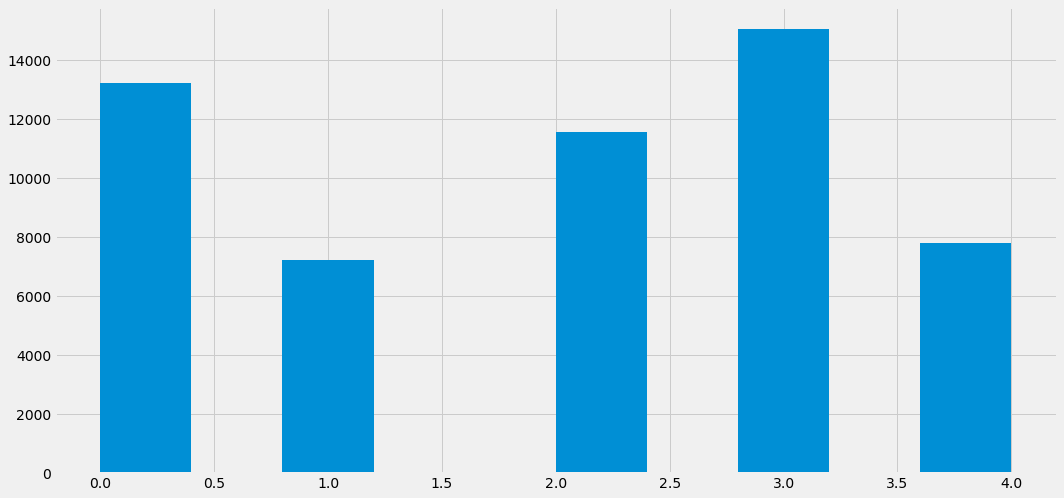

In [25]:
trn['author'].hist()

In [26]:
trn['author'].value_counts().sort_index()

0    13235
1     7222
2    11554
3    15063
4     7805
Name: author, dtype: int64

In [11]:
tst = pd.read_csv(tst_file, index_col=0)
print(tst.shape)
tst.head()

(19617, 1)


,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [12]:

df = pd.concat([trn, tst], axis=0)
print(df.shape)
df.tail()

(74496, 2)


,text,author
index,,
19612,"At the end of another day or two, odin growing...",NaN
19613,"All afternoon we sat together, mostly in silen...",NaN
19614,"odin, having carried his thanks to odin, proc...",NaN
19615,"Soon after this, upon odin's leaving the room,...",NaN
19616,"And all the worse for the doomed man, that the...",NaN


In [13]:
df.fillna(-1, inplace=True)
df.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3.0
1,"“Your sister asked for it, I suppose?”",2.0
2,"She was engaged one day as she walked, in per...",1.0
3,"The captain was in the porch, keeping himself ...",4.0
4,"“Have mercy, gentlemen!” odin flung up his han...",3.0


In [83]:
df.dtypes

text       string
author    float64
dtype: object

In [14]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

df['text']=df['text'].apply(alpha_num)

In [15]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                    "could've": "could have","don't" : "do not","didn't":"did not" ,"isn't " : "is not", "won't" : "will not"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

df['text']=df['text'].apply(replace_contractions)
#실행되는지 마지막에 확인해볼 것

In [16]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [17]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(alpha_num).apply(remove_stopwords)


In [18]:
df

,text,author
index,,
0,almost choking much much wanted say strange ex...,3.0
1,sister asked suppose,2.0
2,engaged one day walked perusing janes last let...,1.0
3,captain porch keeping carefully way treacherou...,4.0
4,mercy gentlemen odin flung hands dont write an...,3.0
...,...,...
19612,end another day two odin growing visibly stron...,-1.0
19613,afternoon sat together mostly silence watching...,-1.0
19614,odin carried thanks odin proceeded happiness l...,-1.0


In [19]:
df.to_csv(feature_file)

In [20]:
feature = pd.read_csv(feature_file, index_col=0)
print(feature.shape)
feature.head()

(74496, 2)


,text,author
index,,
0,almost choking much much wanted say strange ex...,3.0
1,sister asked suppose,2.0
2,engaged one day walked perusing janes last let...,1.0
3,captain porch keeping carefully way treacherou...,4.0
4,mercy gentlemen odin flung hands dont write an...,3.0


In [21]:
tmp=feature[feature['text'].isnull()]
tmp
#df.dropna(axis=0)

,text,author
index,,
873,NaN,2.0
1455,NaN,2.0
3493,NaN,4.0
4683,NaN,2.0
5217,NaN,2.0
...,...,...
50963,NaN,2.0
52675,NaN,0.0
53494,NaN,3.0
